In [3]:
import math
from sklearn.preprocessing import OneHotEncoder
from sklearn import tree
import pandas as pd
import numpy as np

data_folder = "./data/"

#Get and load data
# pitch_14_17_file = "pitcher_2014_2017.csv"
bball_data_2_file = "Baseball Data-2.csv"

In [4]:
#moves 0 value of PlateLocHeight to middle of strikezone from the ground
def normalize_PlateLocHeight(PlateLocHeight):
    return ((PlateLocHeight * 12) - 30)/12

#preprocessing function used to calculate the plate location and isStrike classifier (this will be different than PitchCall (even in terms of BallCalled vs StrikeCalled))
#returns tuple: classification, isStrike
#classification: heart (strike) = 0, shadow (strike) = 1, shadow (ball) = 2, chase (ball) = 3, waste (ball) = 4
def PlateZone(PlateLocHeight, PlateLocSide):

    foot = 12

    #waste outside 84in to 6in, -20in to 20in horizontal, (strike zone * 200%)
    if ((PlateLocHeight > 7 or PlateLocHeight < 0.5) and (PlateLocSide < -(20/foot) or PlateLocSide > (20/foot))):
        return 4

    #heart inside 38in to 22in vertical, -6.7in to 6.7in horizontal, (strike zone size * 67%)
    if ((PlateLocHeight < (38/foot) and PlateLocHeight > (22/foot)) and (PlateLocSide > (-6.7/foot) and PlateLocSide < (6.7/foot))):
        return 0

    #strike zone inside 42in to 18in vertical, -10in to 10in horizontal
    if (PlateLocHeight < (42/foot) and PlateLocHeight > (18/foot) and (PlateLocSide > (-10/foot) and PlateLocSide < (10/foot))):
        return 1

    #shadow inside 46in to 14in vertical, -13.3in to 13.3in horizontal, (strike zone size * 133%)
    if (PlateLocHeight < (46/foot) and PlateLocHeight > (14/foot) and (PlateLocSide > (-13.3/foot) and PlateLocSide < (13.3/foot))):
        return 2

    #chase inside 84in to 6in, -20in to 20in horizontal, (strike zone * 200%)
    return 3

    #preprocessing function used to generate a single number that will be used to classify the ball/strike count before the current pitch 
    #returns int [0 - 11]
def PitchCount(balls, strikes):
    # Strikes: 0  1   2
    # Balls v|---------- 
    #       0| 0  1   2 
    #       1| 3  4   5
    #       2| 6  7   8
    #       3| 9  10  11
    if(balls == 0):
        if(strikes == 0):
            return 0
        if (strikes == 1):
            return 1
        return 2
    if(balls == 1):
        if(strikes == 0):
            return 3
        if (strikes == 1):
            return 4
        return 5
    if(balls == 2):
        if(strikes == 0):
            return 6
        if (strikes == 1):
            return 7
        return 8
    if(balls == 3):
        if(strikes == 0):
            return 9
        if (strikes == 1):
            return 10
        return 11

    #this preprocessing function generates the ground truth hitability of a pitch
    #these values will definitely need to be adjusted and should probably be hyperparameters
def GenerateGroundTruthLabels(pitchCall):
    if pitchCall == 'BallCalled':
        return -1
    if pitchCall == 'BallIntentional' or pitchCall == 'HitByPitch':
        return 0
    if pitchCall == 'StrikeSwinging' or pitchCall == 'StrikeCalled':
        return 1
    else:
        return 2


In [5]:
#import the columns we will need for training and preprocessing
bball_data = pd.read_csv(data_folder+bball_data_2_file, usecols=['Pitcher', 'PitcherThrows', 'Batter', 'BatterSide', 'PitchCall', 'KorBB', 'PlayResult', 'RunsScored', 'VertBreak', 'HorzBreak', 'ZoneSpeed', 'VertApprAngle', 'HorzApprAngle', 'ZoneTime', 'PlateLocHeight', 'PlateLocSide', 'Balls', 'Strikes', 'TaggedPitchType'])
#run preprocessing functions
#bball_data['Zone'] = bball_data.apply(lambda pitch : PlateZone(pitch['PlateLocHeight'], pitch['PlateLocSide']), axis=1) <- removed becasue we are using norm_PlateLocHeight and PlateLocSide
bball_data['BallStrikeNum'] = bball_data.apply(lambda pitch : PitchCount(pitch['Balls'], pitch['Strikes']), axis=1)
bball_data['GroundTruth'] = bball_data.apply(lambda pitch : GenerateGroundTruthLabels(pitch['PitchCall']), axis=1)

#normalize data
bball_data['norm_PlateLocHeight'] = bball_data.apply(lambda pitch : normalize_PlateLocHeight(pitch['PlateLocHeight']), axis=1)

#drop all features we no longer need (ones only used for preprocessing)
bball_data.drop(labels=['PitchCall', 'Pitcher', 'Batter', 'KorBB', 'PlayResult', 'Balls', 'Strikes', 'PitcherThrows','BatterSide','TaggedPitchType'], axis=1, inplace=True)

#categorical_columns = ['Pitcher', 'Batter', 'KorBB', 'PlayResult', 'Zone', 'BallStrikeNum']
# ohe_bball_data = OneHotEncoder(sparse=False)
'''
for category in categorical_columns:
    bball_data[category] = bball_data[category].astype('category')
    # ohe_bball_data.fit_transform(bball_data[[category]])
'''

#Remove NaN valued rows
bball_data.dropna(inplace=True)
bball_data.reset_index(drop=True, inplace=True)

#print the labels of the features we will use to train our network
print(bball_data.keys())
#print(bball_data[bball_data.isna().any(axis=1)])
#print(ohe_bball_data.categories_)

#splitting data into training, validation, testing
total_samples = len(bball_data.index)
training_samples = math.floor(0.7*total_samples)
validation_samples = math.ceil(0.3*total_samples)
#testing_samples = math.ceil(0.2*total_samples)

sum = training_samples+validation_samples#+testing_samples

print("total samples:",total_samples,
        "\ntraining samples:",training_samples,
        "\nvalidation samples:",validation_samples,
        #"\ntesting samples:",testing_samples,
        #"\nsum of training, validation, and test samples:",sum)
        "\nsum of training, and validation:",sum)

#makes shuffled version of the data
indices = np.arange(total_samples)
np.random.shuffle(indices) #TODO get ground truth for data sets using these indices
shuffled_bball_data = bball_data.reindex(indices).reset_index(drop=True)
#gets the amount of random data points as determined by set proportion
training_data = shuffled_bball_data.iloc[0:training_samples]
validation_data = shuffled_bball_data.iloc[training_samples:training_samples+validation_samples]
#testing_data = shuffled_bball_data.iloc[training_samples+validation_samples:training_samples+validation_samples+testing_samples]

training_data

Index(['RunsScored', 'VertBreak', 'HorzBreak', 'PlateLocHeight',
       'PlateLocSide', 'ZoneSpeed', 'VertApprAngle', 'HorzApprAngle',
       'ZoneTime', 'BallStrikeNum', 'GroundTruth', 'norm_PlateLocHeight'],
      dtype='object')
total samples: 1029515 
training samples: 720660 
validation samples: 308855 
sum of training, and validation: 1029515


,RunsScored,VertBreak,HorzBreak,PlateLocHeight,PlateLocSide,ZoneSpeed,VertApprAngle,HorzApprAngle,ZoneTime,BallStrikeNum,GroundTruth,norm_PlateLocHeight
0,0.0,-33.205137,-0.391824,-0.278410,0.439818,76.344027,-9.677646,2.972612,0.468321,10.0,-1,-2.778410
1,0.0,-12.988750,-3.079730,5.874060,-1.379280,83.906100,-2.017628,-0.164680,0.407359,5.0,-1,3.374060
2,0.0,-40.083310,-7.547410,0.688719,-1.145173,74.395284,-9.085041,-4.618664,0.472797,1.0,-1,-1.811281
3,0.0,-45.264280,0.153620,2.524910,0.426040,74.231970,-7.974260,2.910574,0.466856,0.0,1,0.024910
4,0.0,-11.462920,10.458390,2.861010,-0.542460,87.334080,-3.960436,-0.987914,0.393628,8.0,2,0.361010
...,...,...,...,...,...,...,...,...,...,...,...,...
720655,0.0,-12.135015,5.728121,2.371348,-1.977691,82.885553,-5.030707,-3.595393,0.415864,7.0,-1,-0.128652
720656,0.0,-25.144238,13.192999,1.911041,1.044942,82.071090,-6.534185,1.711977,0.425871,1.0,2,-0.588959
720657,0.0,-20.525256,11.367436,1.865888,-0.406763,85.577414,-6.373159,-1.466536,0.401222,0.0,1,-0.634112
720658,0.0,-33.746013,13.792825,2.929058,-0.613376,83.103569,-4.390603,-3.268217,0.419600,0.0,2,0.429058


In [6]:
from sklearn import metrics
#scikit learn doesnt support categorical columns
#non_training_cols = [*categorical_columns, 'PitcherThrows','BatterSide','TaggedPitchType','GroundTruth']
non_training_cols = ['GroundTruth']
X = training_data.loc[:,~training_data.columns.isin(non_training_cols)]
y = training_data.loc[:,training_data.columns == 'GroundTruth']

vX = validation_data.loc[:,~validation_data.columns.isin(non_training_cols)]
vy = validation_data.loc[:,validation_data.columns == 'GroundTruth']

# decision_tree = tree.DecisionTreeClassifier(min_samples_leaf=10000,max_depth=10)

#assigning different values for hyperparameters
#possible_min_leaf_samples = [1,1000,5000,10000,20000,30000,50000,100000,200000]
#possible_depths = [1,2,5,10,20,30,50,100,200]

possible_min_leaf_samples = list(range(1000, 20000, 2000))
possible_depths = list(range(1, 20, 2))

#validation (hyper-parameter tuning)
parameter_accuracy = []
for msl in possible_min_leaf_samples:
    for d in possible_depths:
        #train on training with this iteration of parameters
        decision_tree = tree.DecisionTreeClassifier(min_samples_leaf=msl, max_depth=d)
        decision_tree = decision_tree.fit(X, y)
        #then check accuracy of validation data
        val_pred = decision_tree.predict(vX)
        score = metrics.accuracy_score(vy,val_pred)
        #put parameters and accuracy in matrix
        parameter_accuracy.append((msl,d,score,decision_tree.tree_.node_count))
        print(msl,d,score,decision_tree.tree_.node_count)

#select parameters with highest accuracy
parameter_accuracy.sort(key = lambda x:x[2])

best_parameters = parameter_accuracy[-1]
print(best_parameters)

#train new decision tree using best hyperparameters found above
decision_tree = tree.DecisionTreeClassifier(min_samples_leaf=best_parameters[0], max_depth=best_parameters[1])
decision_tree = decision_tree.fit(X, y)
#test_input = testing_data.loc[:,~testing_data.columns.isin(non_training_cols)] <- replaced with vX
#test_ground_truth = testing_data.loc[:,testing_data.columns == 'GroundTruth'] <- replaced with vY

res_pred = decision_tree.predict(vX)
score = metrics.accuracy_score(vy,res_pred)
print(score*100)

1000 1 0.4420585711741756 3
1000 3 0.5589613248935584 15
1000 5 0.5991063767787473 63
1000 7 0.6312509106214891 207
1000 9 0.6383351410856227 429
1000 11 0.6415826196758997 593
1000 13 0.6512959155590812 735
1000 15 0.6545595829758301 857
1000 17 0.6577746839131632 941
1000 19 0.6583607194314484 1029
3000 1 0.4420585711741756 3
3000 3 0.5589613248935584 15
3000 5 0.5991063767787473 59
3000 7 0.6311473021320685 149
3000 9 0.6375321752926131 203
3000 11 0.6387916659921322 245
3000 13 0.6462773793527707 291
3000 15 0.6488740671188745 311
3000 17 0.6505577050719593 347
3000 19 0.6505577050719593 365
5000 1 0.4420585711741756 3
5000 3 0.5589613248935584 15
5000 5 0.5991063767787473 53
5000 7 0.6314581276003303 109
5000 9 0.6374609444561363 135
5000 11 0.6381117352803095 167
5000 13 0.6425215716112739 181
5000 15 0.6458046656197892 199
5000 17 0.6464619319745512 223
5000 19 0.6464619319745512 227
7000 1 0.4420585711741756 3
7000 3 0.5589613248935584 15
7000 5 0.5991063767787473 53
7000 7 0.6

1029


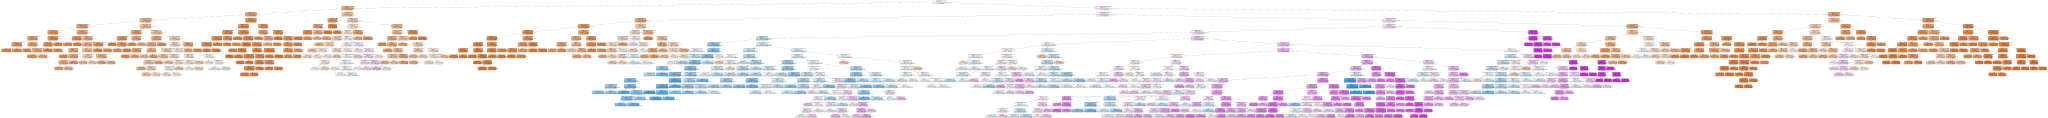

In [7]:
#use graphviz to make pdf and image of tree
import graphviz

# dot_data = tree.export_graphviz(decision_tree,out_file=None)
# graph = graphviz.Source(dot_data)
# graph.render("bball_basic_decision_tree")
print(decision_tree.tree_.node_count)

feature_labels = X.keys()
class_labels = ['BallCalled','BallIntentional/HitByPitch','StrikeSwinging/StrikeCalled',"Correct Swing"]

#tree with recognizable labels and color coded nodes corresponding to classes
dot_data = tree.export_graphviz(decision_tree, out_file=None,
                                feature_names = feature_labels,
                                class_names = class_labels,
                                filled=True, rounded = True,
                                special_characters=True)
graph = graphviz.Source(dot_data)
graph.render("bball_basic_decision_tree_labeled")
graph 